In [2]:
### Core Packages
import pandas as pd
import numpy as np
from scipy.special import softmax
import time

### Visualization Packages
import matplotlib.pyplot as plt

### Machine Learning Packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
import shap

### Setting env
import os, sys

folder = os.getcwd()
if(not(folder.endswith('tcc-machine-learning'))):
        os.chdir('..')
folder = os.getcwd()

### Functions
from dags import config
from dags.utils import chose_path_to_work, save_image, generate_label

### Others
import warnings

c:\Users\Guilherme\anaconda3\envs\tcc-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ticker = 'petr4.sa'
df_ticker = pd.read_csv(f'data/processed/{ticker}_processed.csv', encoding='utf8', delimiter=',')
df_ticker['date'] = pd.to_datetime(df_ticker['date'])

In [7]:
df_ticker_target

,date,open,high,low,close,adj_close,volume,mms_15,mms_30,mms_compra,...,macd,macd_sinal,macd_hist,macd_alta,macd_baixa,%_k,%D,dema,momentum,roc
3790,2015-01-02,9.990000,9.990000,9.350000,9.360000,4.714057,49559500,10.112667,11.526333,0,...,-0.969978,-1.090785,0.120806,0,0,25.203231,45.826841,9.322481,0.299999,3.311250
3791,2015-01-05,9.140000,9.190000,8.530000,8.560000,4.311146,78385100,9.922000,11.391667,0,...,-1.031894,-1.079006,0.047113,0,0,8.962106,26.209008,9.095323,-0.809999,-8.644605
3792,2015-01-06,8.710000,8.830000,8.040000,8.280000,4.170127,84723300,9.748667,11.252667,0,...,-1.090980,-1.081401,-0.009579,0,1,3.828776,12.664704,8.859339,-1.190001,-12.566003
3793,2015-01-07,8.560000,8.730000,8.360000,8.670000,4.366548,85531000,9.618000,11.115667,0,...,-1.093728,-1.083867,-0.009862,0,0,12.716448,8.502443,8.699109,-0.900000,-9.404385
3794,2015-01-08,8.790000,9.390000,8.740000,9.230000,4.648584,83306300,9.554000,10.946667,0,...,-1.038745,-1.074842,0.036097,1,0,32.632781,16.392668,8.628694,-0.600000,-6.103768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5683,2022-08-15,30.879999,32.230000,30.549999,31.719999,31.719999,96759000,33.992667,31.315333,0,...,1.294280,1.494526,-0.200246,0,1,38.991544,58.711079,33.991309,-1.960001,-5.819480
5684,2022-08-16,31.719999,32.070000,31.500000,32.009998,32.009998,64218800,34.059333,31.448000,0,...,1.053501,1.406321,-0.352819,0,0,31.131345,42.667460,33.847946,-1.820004,-5.379850
5685,2022-08-17,31.650000,32.820000,31.600000,32.759998,32.759998,72924700,34.153333,31.617667,0,...,0.912681,1.307593,-0.394912,0,0,35.117674,35.080188,33.808487,-1.090000,-3.220089
5686,2022-08-18,33.099998,33.660000,32.869999,33.419998,33.419998,84552500,34.228666,31.782333,0,...,0.844600,1.214994,-0.370395,0,0,56.681495,40.976838,33.852006,-0.790001,-2.309269


In [6]:
df_ticker_target = df_ticker.loc[df_ticker['date'] >= '2015-01-01']
df_ticker3 = generate_label(3, df_ticker_target)
df_ticker5 = generate_label(5, df_ticker_target)
df_ticker7 = generate_label(7, df_ticker_target)
df_ticker15 = generate_label(15, df_ticker_target)
df_ticker30 = generate_label(30, df_ticker_target)

In [6]:
df_ticker3 = df_ticker3.set_index('date')

transfor = 'normal'
dir_func = np.log if transfor == 'log' else lambda x:x
inf_func = np.exp if transfor == 'log' else lambda x:x

cols_to_transform = [col for col in df_ticker3.columns if not 'target' in col]
df_ticker3[cols_to_transform] = dir_func(df_ticker3[cols_to_transform])

X = df_ticker3.drop(columns = 'target')
y = df_ticker3['target']
feature_names = X.columns

st_feat = MinMaxScaler()
X = X.sort_index(axis = 1)
X = st_feat.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

model = RandomForestClassifier(n_estimators=400, min_samples_leaf=2, 
                                    oob_score=True, bootstrap=True, n_jobs=4)
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, n_estimators=400, n_jobs=4,
                       oob_score=True)

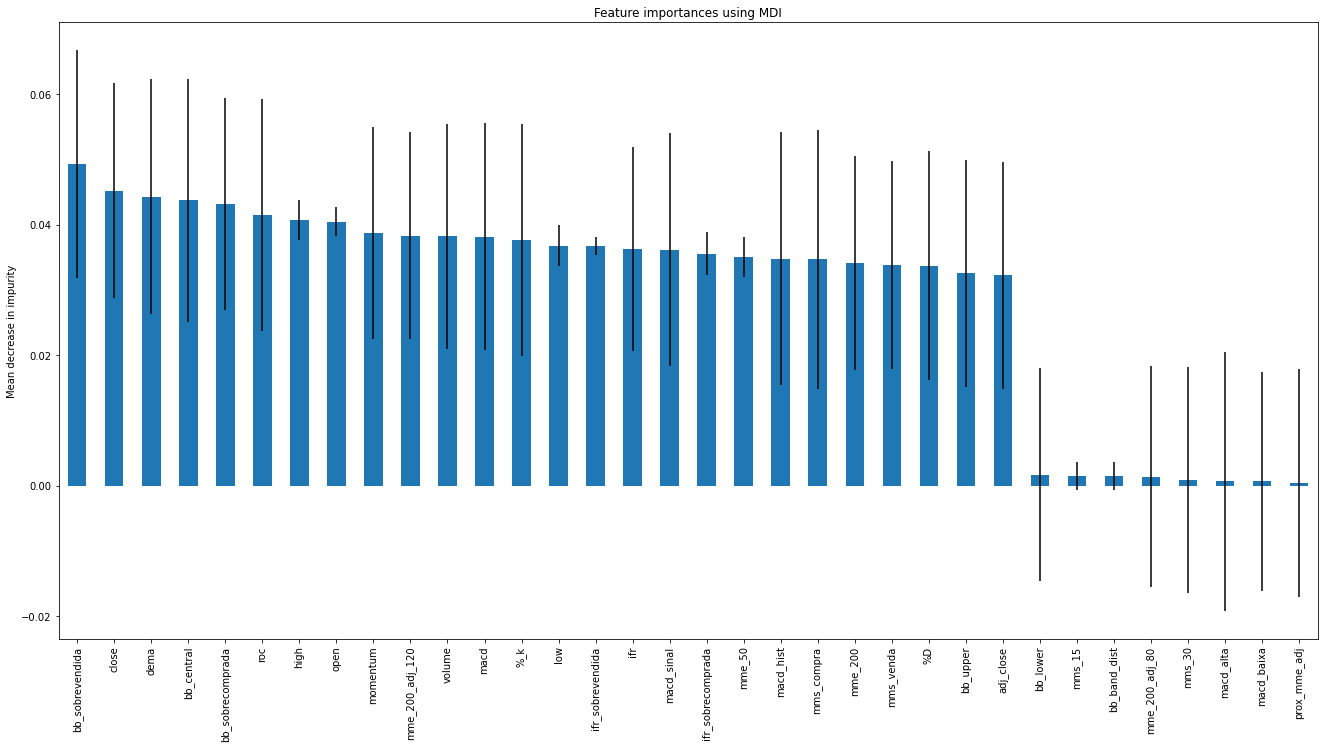

In [14]:
start_time = time.time()
explainer_rf = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

forest_importances = pd.Series(explainer_rf, index=feature_names)
forest_importances = forest_importances.sort_values(ascending = False)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [15]:
explainer_shap = shap.Explainer(model.predict, X_test)
shap_values = explainer_shap(X_test)

Permutation explainer: 475it [05:52,  1.32it/s]                         


In [16]:
def print_feature_importances_shap_values(shap_values, features):
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
 
    importances_norm = softmax(importances)

    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
   
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
  
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")


In [17]:
print_feature_importances_shap_values(shap_values, feature_names)

bb_sobrevendida -> 0.0727 (softmax = 0.0308)
%D -> 0.0635 (softmax = 0.0305)
ifr_sobrecomprada -> 0.0435 (softmax = 0.0299)
mme_200 -> 0.0422 (softmax = 0.0299)
close -> 0.0416 (softmax = 0.0299)
ifr_sobrevendida -> 0.0393 (softmax = 0.0298)
ifr -> 0.0377 (softmax = 0.0297)
dema -> 0.0360 (softmax = 0.0297)
macd -> 0.0357 (softmax = 0.0297)
high -> 0.0339 (softmax = 0.0296)
bb_central -> 0.0320 (softmax = 0.0296)
momentum -> 0.0313 (softmax = 0.0296)
open -> 0.0307 (softmax = 0.0295)
mme_200_adj_120 -> 0.0307 (softmax = 0.0295)
mms_venda -> 0.0304 (softmax = 0.0295)
%_k -> 0.0302 (softmax = 0.0295)
macd_sinal -> 0.0282 (softmax = 0.0295)
low -> 0.0270 (softmax = 0.0294)
bb_sobrecomprada -> 0.0269 (softmax = 0.0294)
volume -> 0.0253 (softmax = 0.0294)
mme_50 -> 0.0250 (softmax = 0.0294)
bb_upper -> 0.0249 (softmax = 0.0294)
roc -> 0.0237 (softmax = 0.0293)
macd_hist -> 0.0236 (softmax = 0.0293)
mms_compra -> 0.0233 (softmax = 0.0293)
adj_close -> 0.0212 (softmax = 0.0293)
mme_200_adj_80

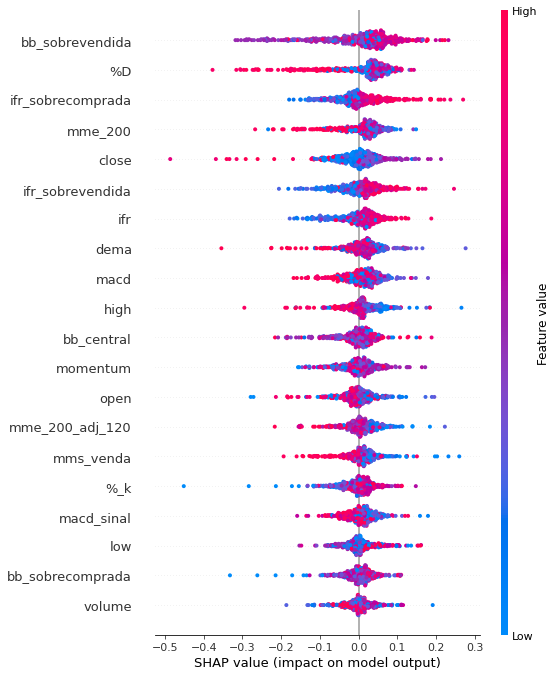

In [18]:
shap.summary_plot(shap_values, feature_names = feature_names)